In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import xgboost as xgb

In [2]:
path = "data/time-series-19-covid-combined.csv"
df = pd.read_csv(path)
df

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0
...,...,...,...,...,...,...
231739,2022-04-12,Zimbabwe,NaN,247094,0.0,5460
231740,2022-04-13,Zimbabwe,NaN,247160,0.0,5460
231741,2022-04-14,Zimbabwe,NaN,247208,0.0,5462
231742,2022-04-15,Zimbabwe,NaN,247237,0.0,5462


In [3]:
df_italy = df[df['Country/Region'] == 'Italy']
df_italy = df_italy.drop('Province/State', axis = 1)
df_italy['Date'] = pd.to_datetime(df_italy['Date'])
df_italy = (df_italy
            .loc[:, ["Date", "Confirmed"]]  # only interested in confirmed cases
            .set_index("Date")
            .diff()         # convert to daily cases
            .iloc[1:]       # remove first row, it is NaN to the .diff()
            .clip(lower=0)) # remove negative values


## Adding More Temporal Features

In [4]:
time_use = 7 #7 days, one week

In [5]:
df_italy["day_of_week"] = df_italy.index.dayofweek
df_italy["is_weekend"] = df_italy["day_of_week"].isin([5, 6]).astype(int)
df_italy["day_of_year"] = df_italy.index.dayofyear
df_italy["month"] = df_italy.index.month
df_italy["week_of_year"] = df_italy.index.isocalendar().week.astype(int)
df_italy["days_since_start"] = (df_italy.index - df_italy.index.min()).days

In [6]:
df_italy[f"rolling_mean_{time_use}"] = df_italy["Confirmed"].shift(1).rolling(window=time_use).mean()
df_italy[f"rolling_std_{time_use}"] = df_italy["Confirmed"].rolling(window=time_use).std()
df_italy.dropna(inplace=True)

In [7]:
df_italy

,Confirmed,day_of_week,is_weekend,day_of_year,month,week_of_year,days_since_start,rolling_mean_7,rolling_std_7
Date,,,,,,,,,
2020-01-30,0.0,3,0,30,1,5,7,0.000000,0.000000
2020-01-31,2.0,4,0,31,1,5,8,0.000000,0.755929
2020-02-01,0.0,5,1,32,2,5,9,0.285714,0.755929
2020-02-02,0.0,6,1,33,2,5,10,0.285714,0.755929
2020-02-03,0.0,0,0,34,2,6,11,0.285714,0.755929
...,...,...,...,...,...,...,...,...,...
2022-04-12,84056.0,1,0,102,4,15,810,63372.714286,17430.454505
2022-04-13,62586.0,2,0,103,4,15,811,62678.714286,17143.471722
2022-04-14,65617.0,3,0,104,4,15,812,61636.000000,16853.834141


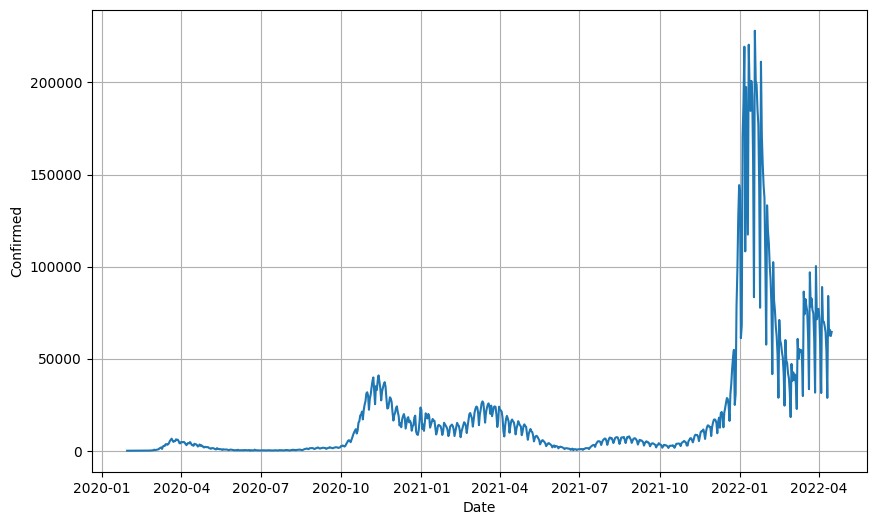

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(df_italy, x = df_italy.index, y = df_italy['Confirmed'])
plt.grid(True)
plt.show()

In [9]:
def create_lag_features(df, n_lags=7):
    df = df.copy()
    df[f"rolling_mean_{time_use}"] = df[f"rolling_mean_{time_use}"].shift(1)
    df[f"rolling_std_{time_use}"] = df[f"rolling_std_{time_use}"].shift(1)
    df["day_of_week"] = df["day_of_week"].shift(1)
    df["day_of_year"] = df["day_of_year"].shift(1)
    df["month"] = df["month"].shift(1)
    df["week_of_year"] = df["week_of_year"].shift(1)
    df["days_since_start"] = df["days_since_start"].shift(1)
    df["is_weekend"] = df["is_weekend"].shift(1)

    for i in range(1, n_lags + 1):
        df[f"lag_{i}"] = df["Confirmed"].shift(i)

    df["target"] = df["Confirmed"]  #this is what we want to predict
    df = df.drop(columns=["Confirmed"])
    df.dropna(inplace=True)
    return df

In [10]:
df_supervised = create_lag_features(df_italy, n_lags=time_use)
df_supervised

,day_of_week,is_weekend,day_of_year,month,week_of_year,days_since_start,rolling_mean_7,rolling_std_7,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target
Date,,,,,,,,,,,,,,,,
2020-02-06,2.0,0.0,36.0,2.0,6.0,13.0,0.285714,0.755929,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-02-07,3.0,0.0,37.0,2.0,6.0,14.0,0.285714,0.755929,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
2020-02-08,4.0,0.0,38.0,2.0,6.0,15.0,0.285714,0.377964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-09,5.0,1.0,39.0,2.0,6.0,16.0,0.142857,0.377964,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-10,6.0,1.0,40.0,2.0,6.0,17.0,0.142857,0.377964,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12,0.0,0.0,101.0,4.0,15.0,809.0,63747.571429,18488.081230,28705.0,53920.0,64421.0,67641.0,70123.0,69885.0,88914.0,84056.0
2022-04-13,1.0,0.0,102.0,4.0,15.0,810.0,63372.714286,17430.454505,84056.0,28705.0,53920.0,64421.0,67641.0,70123.0,69885.0,62586.0
2022-04-14,2.0,0.0,103.0,4.0,15.0,811.0,62678.714286,17143.471722,62586.0,84056.0,28705.0,53920.0,64421.0,67641.0,70123.0,65617.0


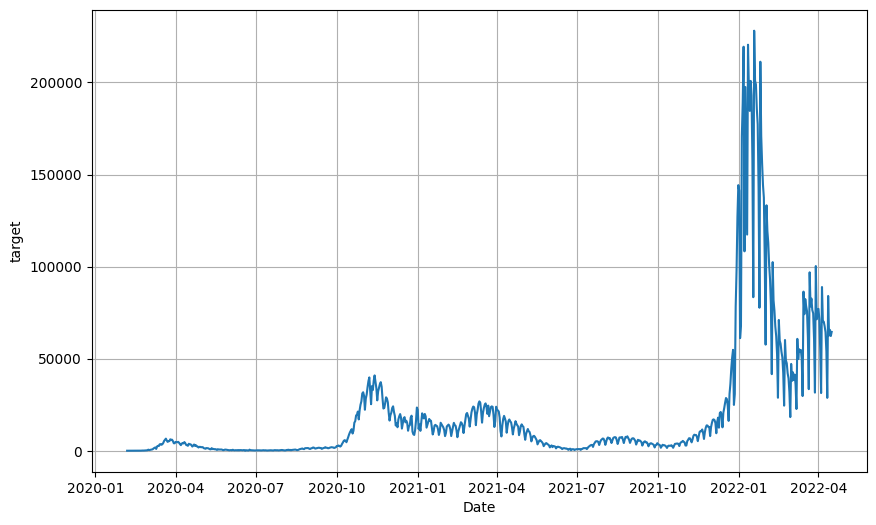

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(df_supervised, x = df_supervised.index, y = df_supervised['target'])
plt.grid(True)
plt.show()

## Grid-SearchCV Parameters

In [12]:
param_grid = {
    'n_estimators': [100, 300, 600, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

scorer = make_scorer(mean_squared_error, greater_is_better=False)

tscv = TimeSeriesSplit()


In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, param_grid, tscv, title = ""):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    grid_search = GridSearchCV(
        estimator = xgb_model,
        param_grid = param_grid,
        scoring = scorer,
        cv = tscv,
        verbose = 1,
        n_jobs = -1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print("Best Parameters Found:")
    print(grid_search.best_params_)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    # Plot
    plt.figure(figsize = (12, 6))
    plt.plot(y_train.index, y_train, label="Train", color='blue')
    plt.plot(y_test.index, y_test, label="Real", color='orange')
    plt.plot(y_test.index, y_pred, label="Forecast", linestyle='--', color='green')
    plt.title(f"Forecasting Daily COVID-19 Cases in Italy {title}")
    plt.xlabel("Date")
    plt.ylabel("Daily Confirmed Cases")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_model


In [ ]:
def plot_feature_importance(model, top_n = 10):
    fi = pd.DataFrame(data = model.feature_importances_,
                      index = model.feature_names_in_,
                      columns = ['importance'])
    fi_sorted = fi.sort_values('importance', ascending = False)
    print(fi_sorted.head(top_n))
    fi_sorted.head(top_n).plot(kind='barh', title = f'Top {top_n} Feature Importances')
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Predict Italy's COVID-19 daily cases (Jan–Jun 2020)

Filter training and prediction range. Train on data before January 2020 (we won’t have any). So instead, we’ll train on January–May 2020 and predict for June 2020



In [15]:
train = df_supervised.loc["2020-01-23":"2020-05-31"]
test = df_supervised.loc["2020-06-01":"2020-06-30"]

X_train = train.drop("target", axis=1)
y_train = train["target"]
X_test = test.drop("target", axis=1)
y_test = test["target"]

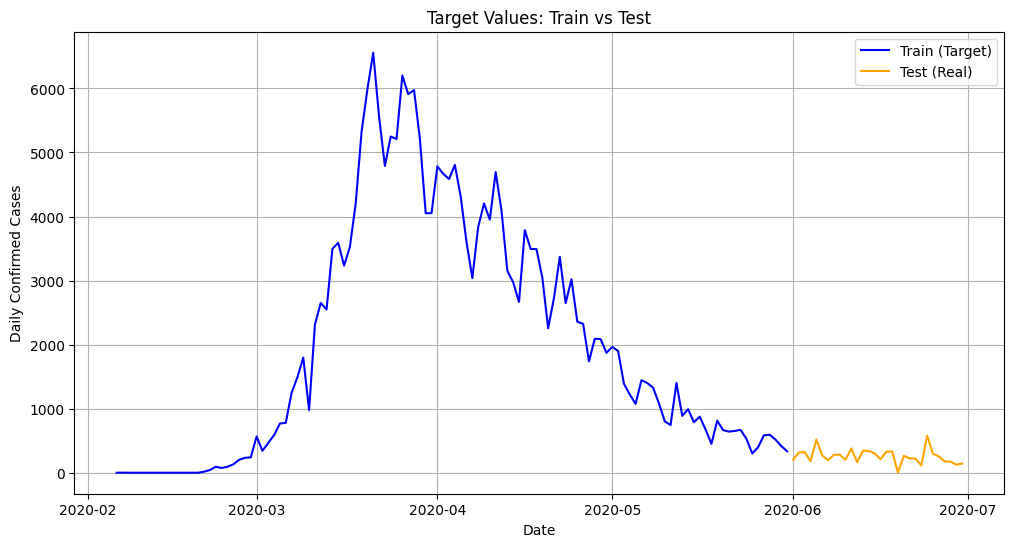

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Train (Target)", color="blue")
plt.plot(y_test.index, y_test, label="Test (Real)", color="orange") 
plt.legend()
plt.grid(True)
plt.title("Target Values: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Daily Confirmed Cases")
plt.show()

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
RMSE: 201.92
MAE: 178.57


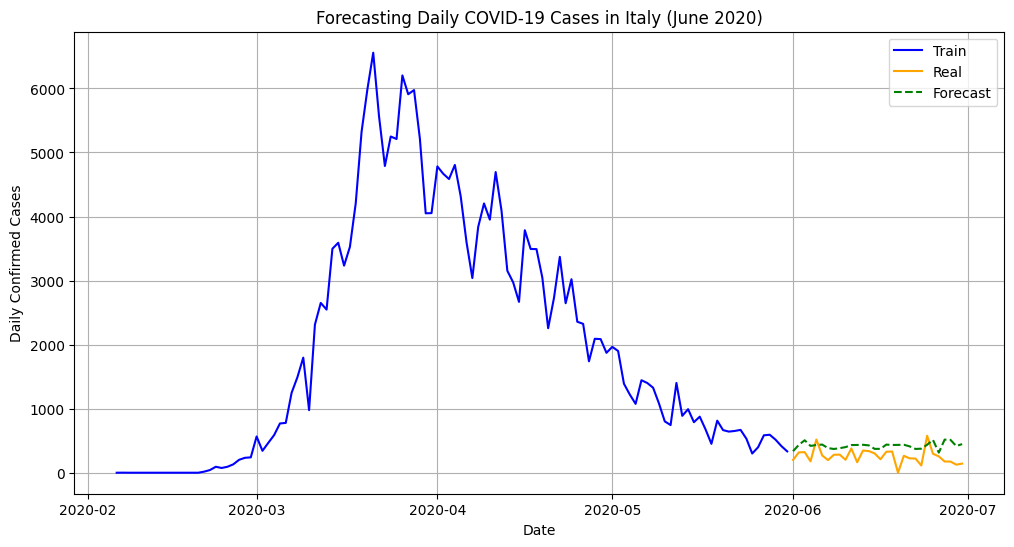

In [17]:
best_model_june = train_and_evaluate(X_train, y_train, X_test, y_test, param_grid, tscv, title="(June 2020)")

                  importance
lag_1               0.691191
lag_2               0.236596
rolling_std_7       0.024350
day_of_year         0.018714
lag_3               0.007322
lag_4               0.005781
days_since_start    0.005674
lag_7               0.003336
rolling_mean_7      0.002434
lag_6               0.001334


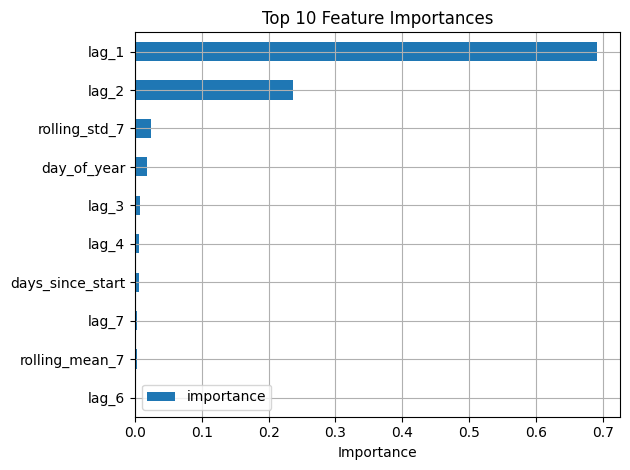

In [18]:
plot_feature_importance(best_model_june)

## Predict Italy's COVID-19 daily cases (Jul-Dec 2020)

In [19]:
train = df_supervised.loc["2020-07-01":"2020-11-30"] #between jult and november cases
test = df_supervised.loc["2020-12-01":"2020-12-31"] #december cases

X_train = train.drop("target", axis=1)
y_train = train["target"]
X_test = test.drop("target", axis=1)
y_test = test["target"]

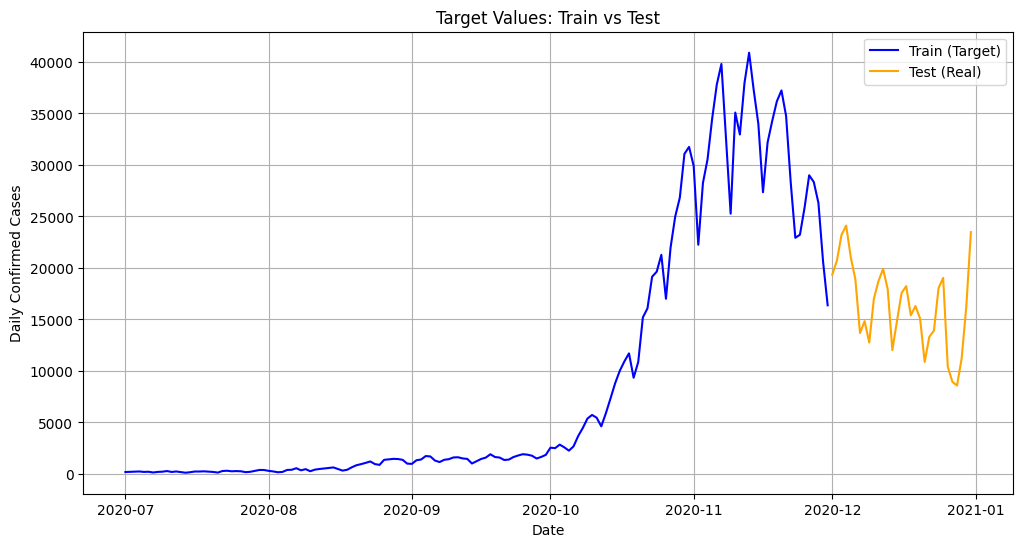

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Train (Target)", color="blue")
plt.plot(y_test.index, y_test, label="Test (Real)", color="orange") 
plt.legend()
plt.grid(True)
plt.title("Target Values: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Daily Confirmed Cases")
plt.show()

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
RMSE: 3896.75
MAE: 3069.18


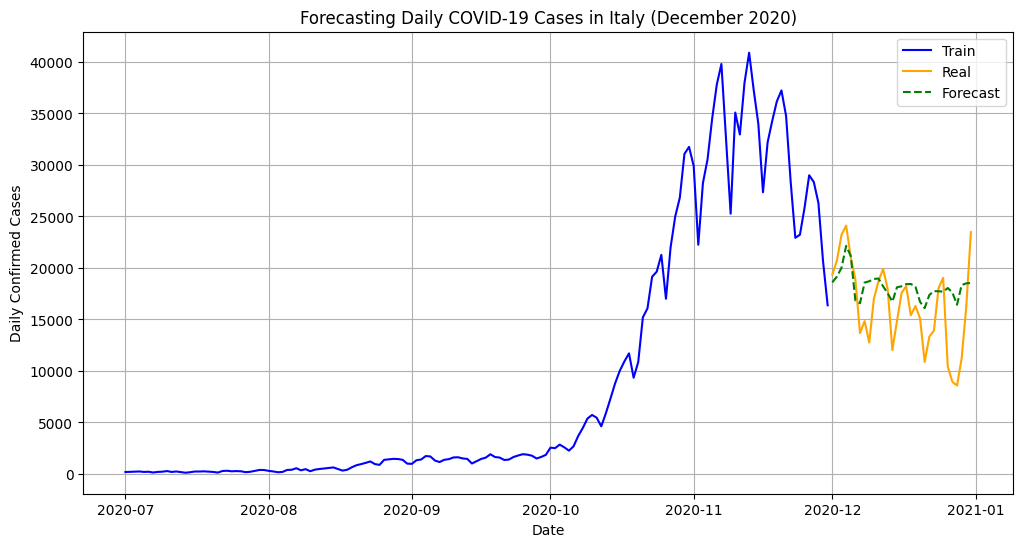

In [21]:
best_model_december = train_and_evaluate(X_train, y_train, X_test, y_test, param_grid, tscv, title="(December 2020)")

                  importance
day_of_year         0.541590
days_since_start    0.352956
lag_7               0.033633
lag_1               0.024309
rolling_std_7       0.024152
lag_3               0.014891
lag_6               0.003516
day_of_week         0.002227
is_weekend          0.000762
lag_2               0.000593


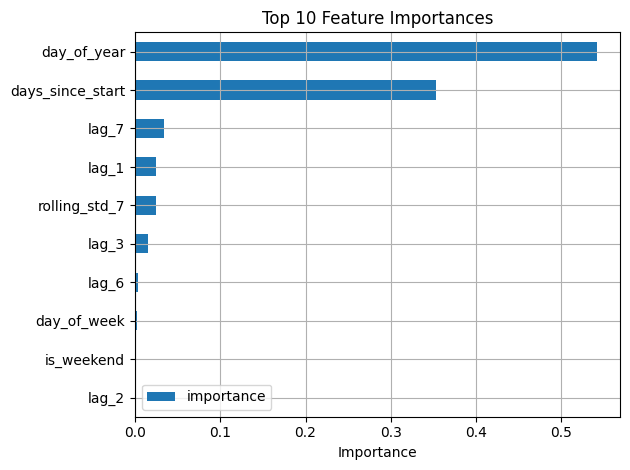

In [22]:
plot_feature_importance(best_model_december)